This notebook includes functions for plotting the figures reported in the paper.

In [1]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [2]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [3]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [4]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [5]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [6]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/sm_nov25/all_plots


In [7]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/nov25/zl5_11212023/results"

# Directory to save figures
PLOT_DIR = "figures_zl5_11212023"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [8]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [9]:
folders = ["baseline"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.8945448650372367]
values [0.9070001509092227]
values [0.8989217790238133]
values [0.8900568124771628]
values [0.8915703863180099]
Overall quality when there is no bots: 0.9


# Shuffle 
Effects of network structure on Quality

In [10]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.638575,0.660021,0.639434,0.660562,0.645748,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.571217,0.580875,0.529092,0.566801,0.595543,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.659165,0.676496,0.667827,0.677871,0.661894,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.869074,0.866072,0.873026,0.860708,0.862748,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.824089,0.858010,0.857659,0.843969,0.859551,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.852608,0.845504,0.869649,0.869783,0.867548,community_shuffle__None2.json,community


In [11]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_5runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

In [12]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,shuffle
54,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.829054,0.832893,0.820824,0.850224,0.838091,None


In [13]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.638575,0.660021,0.639434,0.660562,0.645748,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.571217,0.580875,0.529092,0.566801,0.595543,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.659165,0.676496,0.667827,0.677871,0.661894,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.869074,0.866072,0.873026,0.860708,0.862748,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.824089,0.858010,0.857659,0.843969,0.859551,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.852608,0.845504,0.869649,0.869783,0.867548,community_shuffle__None2.json,community


In [14]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [15]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,shuffle,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.829054,...,0.850224,0.838091,None,NaN,0.924851,0.929134,0.915671,0.948468,0.934932,0
1,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.638575,...,0.660562,0.645748,community,community_shuffle__None3.json,0.712362,0.736287,0.713321,0.736890,0.720365,1
2,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.571217,...,0.566801,0.595543,hub,hub_shuffle__None3.json,0.637222,0.647995,0.590228,0.632295,0.664358,2
3,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.659165,...,0.677871,0.661894,all,all_shuffle__None3.json,0.735332,0.754666,0.744994,0.756199,0.738375,3
4,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.869074,...,0.860708,0.862748,all,all_shuffle__None2.json,0.969495,0.966147,0.973904,0.960162,0.962438,4
5,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.824089,...,0.843969,0.859551,hub,hub_shuffle__None2.json,0.919313,0.957153,0.956762,0.941490,0.958872,5
6,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.852608,...,0.869783,0.867548,community,community_shuffle__None2.json,0.951127,0.943202,0.970137,0.970287,0.967793,6


In [16]:
results

,id,run_no,quality_4,phi,rho,quality_1,shuffle,beta,quality_3,targeting_criterion,epsilon,file_name,graph_gml,gamma,quality_2,theta,mu,quality_0,relative_quality_
0,0,0,0.838091,0.0,0.8,0.832893,None,0.05,0.850224,none,0.0001,NaN,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.820824,1,0.5,0.829054,0.924851
1,1,0,0.645748,0.0,0.8,0.660021,community,0.05,0.660562,none,0.0001,community_shuffle__None3.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.10,0.639434,1,0.5,0.638575,0.712362
2,2,0,0.595543,0.0,0.8,0.580875,hub,0.05,0.566801,none,0.0001,hub_shuffle__None3.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.10,0.529092,1,0.5,0.571217,0.637222
3,3,0,0.661894,0.0,0.8,0.676496,all,0.05,0.677871,none,0.0001,all_shuffle__None3.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.10,0.667827,1,0.5,0.659165,0.735332
4,4,0,0.862748,0.0,0.8,0.866072,all,0.05,0.860708,none,0.0001,all_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.873026,1,0.5,0.869074,0.969495
5,5,0,0.859551,0.0,0.8,0.858010,hub,0.05,0.843969,none,0.0001,hub_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.857659,1,0.5,0.824089,0.919313
6,6,0,0.867548,0.0,0.8,0.845504,community,0.05,0.869783,none,0.0001,community_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.869649,1,0.5,0.852608,0.951127
7,0,1,0.838091,0.0,0.8,0.832893,None,0.05,0.850224,none,0.0001,NaN,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.820824,1,0.5,0.829054,0.929134
8,1,1,0.645748,0.0,0.8,0.660021,community,0.05,0.660562,none,0.0001,community_shuffle__None3.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.10,0.639434,1,0.5,0.638575,0.736287
9,2,1,0.595543,0.0,0.8,0.580875,hub,0.05,0.566801,none,0.0001,hub_shuffle__None3.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.10,0.529092,1,0.5,0.571217,0.647995


Plot data for default values $\gamma=0.01$

In [17]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,quality_4,phi,rho,quality_1,shuffle,beta,quality_3,targeting_criterion,epsilon,file_name,graph_gml,gamma,quality_2,theta,mu,quality_0,relative_quality_
0,0,0,0.838091,0.0,0.8,0.832893,None,0.05,0.850224,none,0.0001,NaN,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.820824,1,0.5,0.829054,0.924851
4,4,0,0.862748,0.0,0.8,0.866072,all,0.05,0.860708,none,0.0001,all_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.873026,1,0.5,0.869074,0.969495
5,5,0,0.859551,0.0,0.8,0.858010,hub,0.05,0.843969,none,0.0001,hub_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.857659,1,0.5,0.824089,0.919313
6,6,0,0.867548,0.0,0.8,0.845504,community,0.05,0.869783,none,0.0001,community_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.869649,1,0.5,0.852608,0.951127
7,0,1,0.838091,0.0,0.8,0.832893,None,0.05,0.850224,none,0.0001,NaN,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.820824,1,0.5,0.829054,0.929134


In [18]:
# !pip install statannotations

In [19]:
plot_data

,id,run_no,quality_4,phi,rho,quality_1,shuffle,beta,quality_3,targeting_criterion,epsilon,file_name,graph_gml,gamma,quality_2,theta,mu,quality_0,relative_quality_
0,0,0,0.838091,0.0,0.8,0.832893,None,0.05,0.850224,none,0.0001,NaN,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.820824,1,0.5,0.829054,0.924851
4,4,0,0.862748,0.0,0.8,0.866072,all,0.05,0.860708,none,0.0001,all_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.873026,1,0.5,0.869074,0.969495
5,5,0,0.859551,0.0,0.8,0.858010,hub,0.05,0.843969,none,0.0001,hub_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.857659,1,0.5,0.824089,0.919313
6,6,0,0.867548,0.0,0.8,0.845504,community,0.05,0.869783,none,0.0001,community_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.869649,1,0.5,0.852608,0.951127
7,0,1,0.838091,0.0,0.8,0.832893,None,0.05,0.850224,none,0.0001,NaN,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.820824,1,0.5,0.829054,0.929134
11,4,1,0.862748,0.0,0.8,0.866072,all,0.05,0.860708,none,0.0001,all_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.873026,1,0.5,0.869074,0.966147
12,5,1,0.859551,0.0,0.8,0.858010,hub,0.05,0.843969,none,0.0001,hub_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.857659,1,0.5,0.824089,0.957153
13,6,1,0.867548,0.0,0.8,0.845504,community,0.05,0.869783,none,0.0001,community_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.869649,1,0.5,0.852608,0.943202
14,0,2,0.838091,0.0,0.8,0.832893,None,0.05,0.850224,none,0.0001,NaN,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.820824,1,0.5,0.829054,0.915671
18,4,2,0.862748,0.0,0.8,0.866072,all,0.05,0.860708,none,0.0001,all_shuffle__None2.json,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0.01,0.873026,1,0.5,0.869074,0.973904


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:5.095e-03 t=3.820e+00
hubs vs. communities: Welch's t-test independent samples, P_val:1.833e-01 t=-1.468e+00
random vs. hubs: Welch's t-test independent samples, P_val:5.698e-02 t=2.487e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:1.292e-03 t=5.984e+00


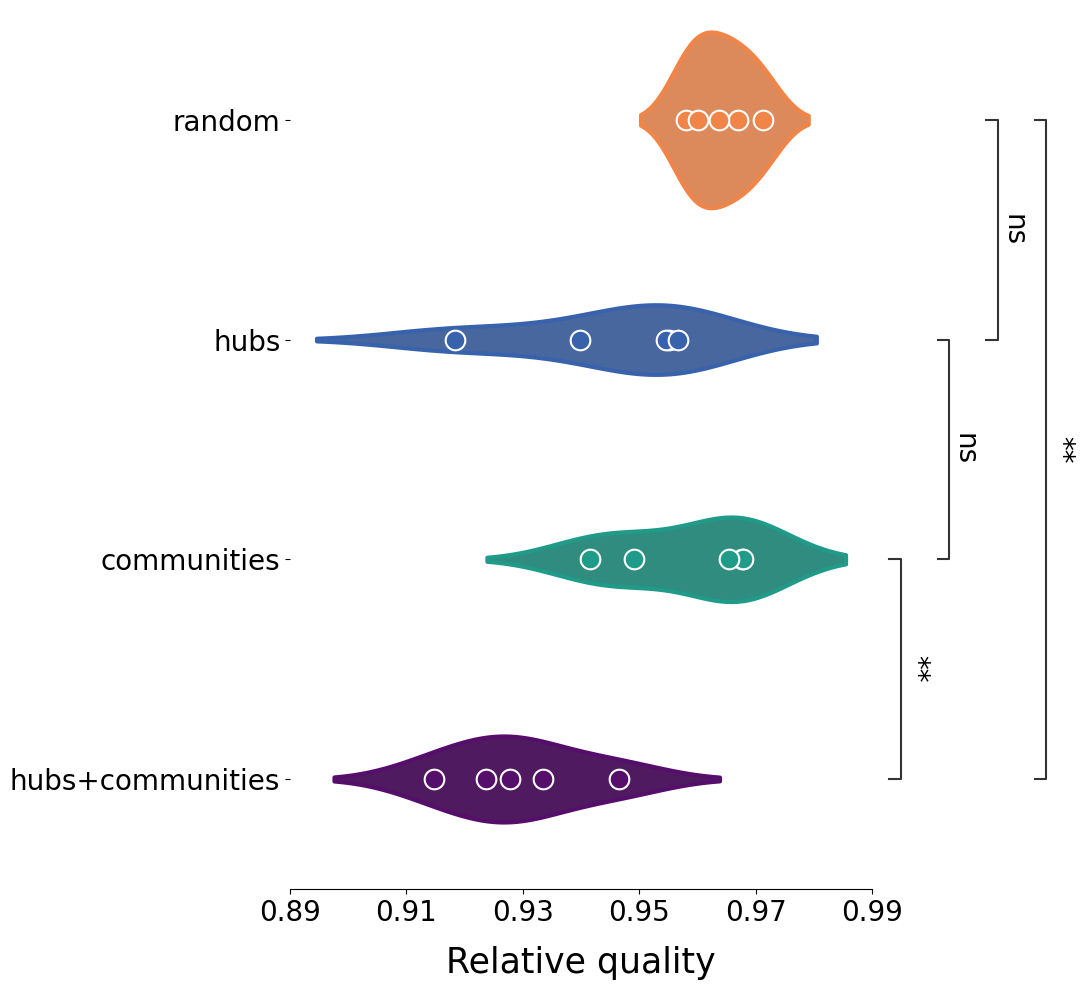

In [20]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
patch_violinplot(ax, palette=BLUEPALETTE, n=4)
point_violinplot(ax, palette=BLUEPALETTE, n=4)
sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [21]:
folders = ["vary_alpha"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

,id,run_no,phi,relative_quality_0,rho,relative_quality_2,relative_quality_3,beta,targeting_criterion,epsilon,graph_gml,gamma,relative_quality_1,relative_quality_4,theta,alpha,mu,quality_
13,5,1,0,1.005438,0.8,1.015112,1.008589,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,0.992309,1.009912,1,1,0.5,0.889524
5,5,0,0,1.005438,0.8,1.015112,1.008589,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,0.992309,1.009912,1,1,0.5,0.901294
21,5,2,0,1.005438,0.8,1.015112,1.008589,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,0.992309,1.009912,1,1,0.5,0.909965
37,5,4,0,1.005438,0.8,1.015112,1.008589,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,0.992309,1.009912,1,1,0.5,0.905304
29,5,3,0,1.005438,0.8,1.015112,1.008589,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,0.992309,1.009912,1,1,0.5,0.904118


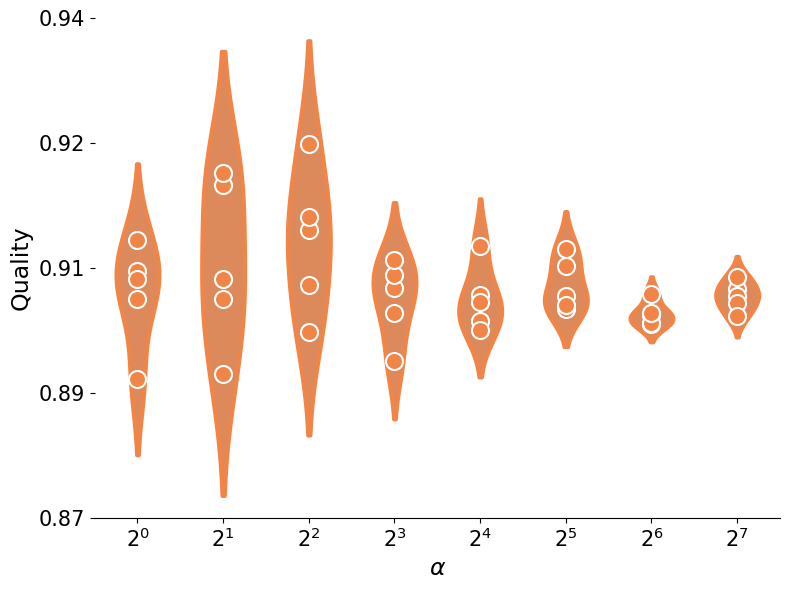

In [22]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [23]:
# Read data
data = read_data(RES_DIR, ["vary_mu"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,phi,rho,beta,targeting_criterion,epsilon,graph_gml,gamma,theta,alpha,mu,quality_
3,3,0,0,0.8,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,1,15,0.1,0.897992
8,3,1,0,0.8,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,1,15,0.1,0.894968
18,3,3,0,0.8,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,1,15,0.1,0.901869
23,3,4,0,0.8,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,1,15,0.1,0.894042
13,3,2,0,0.8,0,none,0.0001,/N/project/simsom/simsom_v3/10242023_v3.3/data...,0,1,15,0.1,0.885636


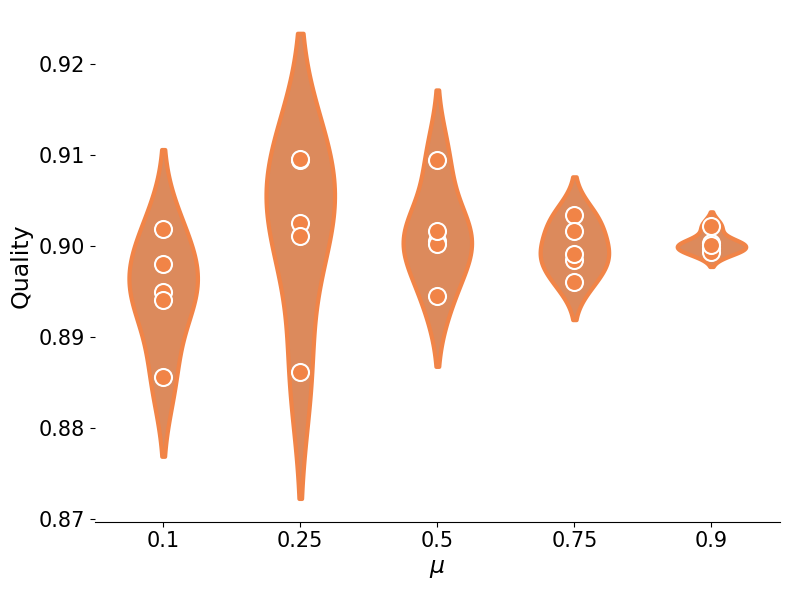

In [24]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [25]:
data = read_data(
    RES_DIR, folders=["vary_thetaphi_5runs"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
# thetaphi

### Phigamma

In [26]:
data = read_data(
    RES_DIR, folders=["vary_phigamma"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
# phigamma

### Thetagamma

In [27]:
data = read_data(RES_DIR, folders=["vary_thetagamma_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

In [28]:
thetagamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,alpha
0,4,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.890364,0.874236,0.886669,0.888173,0.888437,15
1,8,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.770334,0.762334,0.792298,0.782464,0.781768,15
2,32,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.869695,0.878599,0.886272,0.888211,0.872210,15
3,16,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.467638,0.485988,0.465711,0.466018,0.468723,15
4,16,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.880924,0.893995,0.875736,0.876733,0.884926,15
5,8,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.895055,0.898538,0.903900,0.901719,0.900053,15
6,32,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.887238,0.898823,0.890528,0.908399,0.894676,15
7,64,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.900583,0.891994,0.891560,0.891950,0.892182,15
8,16,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.895573,0.894672,0.900872,0.896799,0.907222,15
9,8,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.874710,0.887113,0.884392,0.884808,0.882230,15


## Single param plots
Subset data (only plot default values for each panel)

In [29]:
# VARYING GAMMA
vary_gamma = thetagamma[thetagamma.theta==1]
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = phigamma[phigamma.gamma == 0.01]
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
x = vary_phi["phi"]
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = thetaphi[thetaphi.phi == 0]
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9904437916061932, 1.0010871048152676, 0.9934000529472814, 0.9887418245975688, 0.9977036873534955]
values [1.0088355657978392, 1.0027017918835375, 1.0080013810158606, 1.0030699610245062, 0.9938811821034229]
values [0.6209483868323689, 0.6512573120427545, 0.6838210537389244, 0.6286619585631318, 0.6654957764096691]
values [0.9474281106398522, 0.9267905149685982, 0.9501641626305457, 0.9484933060562547, 0.9548280456816977]
values [0.7637666360571395, 0.7273639532518804, 0.7446256720741895, 0.7405027892266035, 0.7349842772038675]
values [0.7363242307977151, 0.7294346367009908, 0.7353503178083614, 0.7203034416036961, 0.7519816533505117]
values [0.795006481532432, 0.7673719068593247, 0.8010361697452024, 0.7983554310815381, 0.7802858516200084]
values [0.7215636526189021, 0.7535090822972466, 0.7305991143471885, 0.7067199577346497, 0.7605922857512958]
values [0.8066090848386495, 0.7782523974434575, 0.7890475914035218, 0.7741710187580289, 0.777516803028717]
values [0.7214606356422707, 0.

In [30]:
vary_gamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_4,alpha,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,mean_relative_quality,std_relative_quality,ci_relative_quality
10,1,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.887852,...,0.894360,15,0.990444,1.001087,0.993400,0.988742,0.997704,0.994275,0.005104,0.006338
16,1,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.904339,...,0.890934,15,1.008836,1.002702,1.008001,1.003070,0.993881,1.003298,0.005955,0.007395
22,1,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.556630,...,0.596563,15,0.620948,0.651257,0.683821,0.628662,0.665496,0.650037,0.025908,0.032169
25,1,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.849292,...,0.855926,15,0.947428,0.926791,0.950164,0.948493,0.954828,0.945541,0.010857,0.013481


### Plot

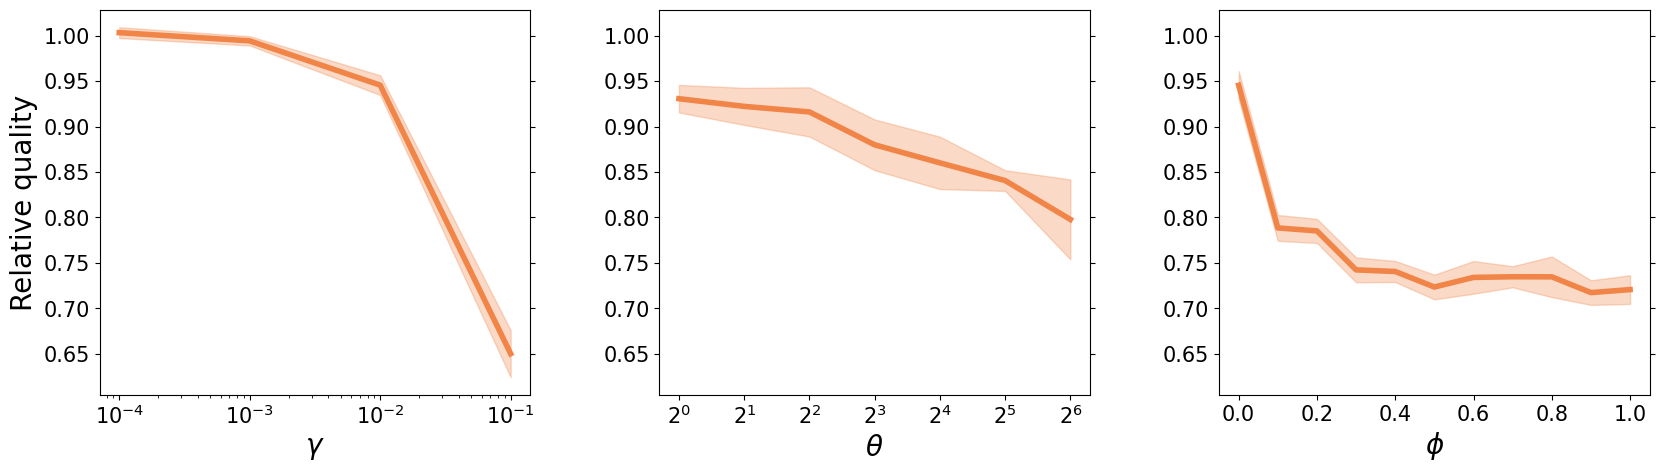

In [31]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

# Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [32]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=['theta','phi'], keep='first')
thetaphi = thetaphi.pivot(index='theta', columns='phi', values='mean_relative_quality').reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ['theta']+PHI
thetaphi.head()

values [0.7112640100623818, 0.7067208088760915, 0.7164115520634526, 0.7308673812443914, 0.7155949829436047]
values [0.6400020246816835, 0.6221810960170239, 0.6270537551439193, 0.6284403510682331, 0.671987174701654]
values [0.6348984674164863, 0.6593875367458937, 0.6561493215940521, 0.6556267532382307, 0.6469565972453003]
values [0.7577946521739095, 0.7398655528048084, 0.7506130924221226, 0.7335656993783293, 0.745925819590215]
values [0.6945971916372398, 0.6918594840815555, 0.7062904797607563, 0.7049679230471203, 0.7171293119883111]
values [0.7384726123643851, 0.7045301597846098, 0.7218350234807137, 0.7286691549713243, 0.7337671755091346]
values [0.6456223518396036, 0.6513242550134585, 0.6464528223763283, 0.6430159835529301, 0.6615589309000136]
values [0.6535138421012933, 0.647107802559669, 0.6278908712050318, 0.6242857348573915, 0.6422384629285898]
values [0.6573929662510561, 0.6592351181019432, 0.659769947084554, 0.6433502133187607, 0.648544380036867]
values [0.7060277752588752, 0.694

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.930611,0.762607,0.758165,0.756207,0.738494,0.740426,0.724790,0.728279,0.722633,0.732264,0.722648
1,2,0.922145,0.759981,0.739325,0.733001,0.716172,0.718258,0.710701,0.712791,0.703529,0.703040,0.695458
2,4,0.916052,0.745553,0.725830,0.713074,0.696338,0.695615,0.690115,0.697941,0.689510,0.679376,0.675624
3,8,0.879853,0.734242,0.702969,0.695217,0.701462,0.687941,0.672053,0.676786,0.668372,0.663632,0.661571
4,16,0.860010,0.718747,0.703789,0.700896,0.681315,0.675905,0.663139,0.659915,0.653659,0.655190,0.646613


In [33]:
tp_matrix = thetaphi.loc[:,PHI].values
#Check shape:
tp_matrix.shape 

(7, 11)

### Data: Thetagamma matrix

In [34]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=['theta','gamma'], keep='first')
thetagamma = thetagamma.pivot(index='theta', columns='gamma', values='mean_relative_quality').reset_index()
thetagamma.head()

values [0.9932450781291406, 0.9752536066980901, 0.9891241239053069, 0.9908009831696697, 0.9910962041620153]
values [0.8593464028449515, 0.8504216528316375, 0.8838476672433182, 0.8728778619225951, 0.8721009707856399]
values [0.970188176651601, 0.9801211897191007, 0.9886804965495147, 0.9908433589704275, 0.9729933738262546]
values [0.521673353367845, 0.5421440129854571, 0.5195239093301673, 0.5198661835284396, 0.5228841008903172]
values [0.982715023813966, 0.9972960831127162, 0.9769273557124745, 0.978039016384675, 0.9871790728256257]
values [0.9984781345683568, 1.002364601320851, 1.0083456215804343, 1.0059128041584584, 1.0040540416686552]
values [0.9897586254300238, 1.0026821792950498, 0.9934283189113013, 1.0133642719646452, 0.9980554239388404]
values [1.0046450909618854, 0.9950641217159638, 0.994579616933109, 0.9950151071896183, 0.9952738755689821]
values [0.9990561109449619, 0.998051105179353, 1.0049677441086258, 1.0004243937205062, 1.0120509561117277]
values [0.9757824089521694, 0.98961

gamma,theta,0.0001,0.001,0.01,0.1
0,1,1.003298,0.994275,0.945541,0.650037
1,2,1.006377,0.994502,0.925812,0.623369
2,4,1.005517,0.987904,0.912953,0.571749
3,8,1.003831,0.984641,0.867719,0.546648
4,16,1.002910,0.984431,0.842249,0.525218


In [35]:
tg_matrix = thetagamma.loc[:,GAMMA].values
tg_matrix.shape

(7, 4)

### Data: Phigamma matrix

In [36]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=['phi','gamma'], keep='first')
phigamma = phigamma.pivot(index='phi', columns='gamma', values='mean_relative_quality').reset_index()
phigamma.head()

values [0.8668889306167769, 0.8600265405215104, 0.842042526585447, 0.8573971269284518, 0.9132510035919302]
values [0.7637666360571395, 0.7273639532518804, 0.7446256720741895, 0.7405027892266035, 0.7349842772038675]
values [0.8187729546538536, 0.8348800066799625, 0.8216769272227766, 0.8085018578547184, 0.8071203464631147]
values [0.89379246720436, 0.9113321005389018, 0.9033036969568514, 0.9406012221524556, 0.968974171777519]
values [0.8022115042273041, 0.8279342629788582, 0.8143861708856183, 0.8646324693265965, 0.8274466480126008]
values [0.529744853340984, 0.5175483524071938, 0.5278327327534035, 0.5150651981022676, 0.5106652032731552]
values [0.8855114636712142, 0.8514935439295198, 0.8004943896558904, 0.855598307603601, 0.8362678073390608]
values [0.7363242307977151, 0.7294346367009908, 0.7353503178083614, 0.7203034416036961, 0.7519816533505117]
values [1.0157345910757234, 0.9718952049365257, 0.9898335893609816, 0.9008490845884672, 0.9963272071608109]
values [0.8030727693564537, 0.8572

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,1.007074,0.983908,0.945360,0.654907
1,0.1,0.992365,0.898357,0.788411,0.571188
2,0.2,0.978001,0.867921,0.785119,0.553092
3,0.3,0.974928,0.860033,0.742249,0.530518
4,0.4,1.001619,0.845873,0.740474,0.520171


In [37]:
pg_matrix = phigamma.loc[:,GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

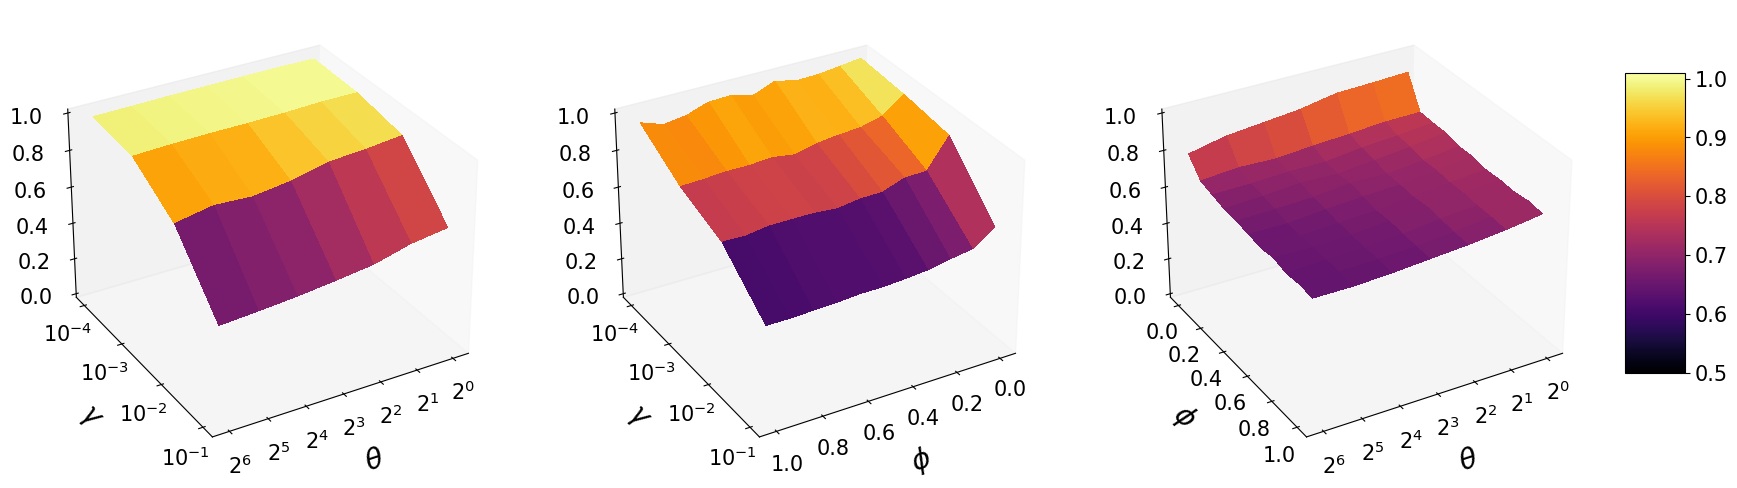

In [38]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet 
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238

def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$" 
  
fpath = os.path.join(PLOT_DIR, "joint")  
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1,3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN=np.round(min_qual,2)
VMAX=np.round(max_qual,2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA              
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax=axs[0]
surf = ax.plot_surface(np.log2(X), np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) #Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


# ## PHIGAMMA              
ax=axs[1]

X=PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX
                          )

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, .27, .03, .5])# x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, 
             cax=cbar_ax
            )


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax=axs[2]
surf = ax.plot_surface(np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0,1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [39]:
data = read_data(RES_DIR, folders=["strategies_5runs"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. hubs: Welch's t-test independent samples, P_val:1.264e-02 t=-3.208e+00
random vs. misinformation: Welch's t-test independent samples, P_val:2.875e-03 t=-4.242e+00
random vs. liberal: Welch's t-test independent samples, P_val:7.307e-05 t=-1.177e+01
random vs. conservative: Welch's t-test independent samples, P_val:8.468e-05 t=-7.342e+00


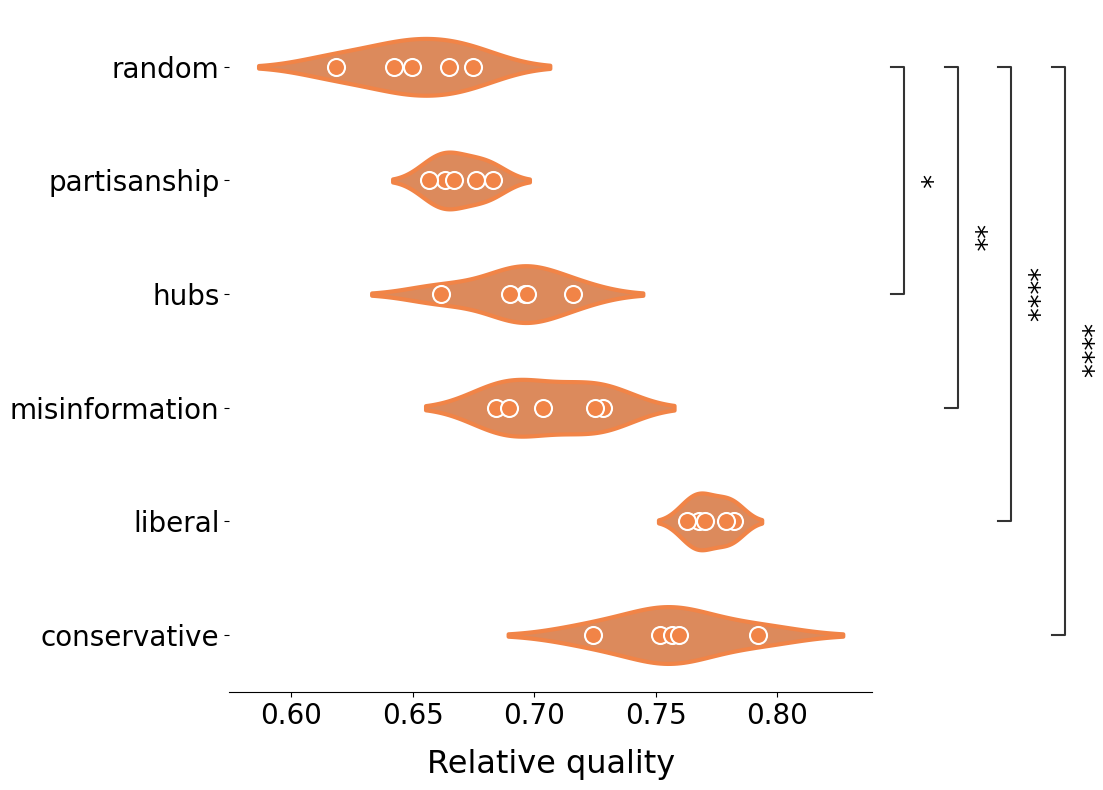

In [40]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()